<a href="https://colab.research.google.com/github/entruv/code_stream/blob/master/03_12_2020_Implementer_MCTS_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Entrainer MCTSAI

- Importer la classe  MCTSAI qui correspond a l'arbre
- Importer la classe BoardAi qui correspond aux noeuds
- Importer le modele 

### Helpers



In [0]:
d = {}
l = []

In [129]:
def create_one_hot(pieces):
  possibilities = pieces + [piece.upper() for piece in pieces]
  print(len(possibilities))

  one_hot_dictionary = {}
  one_hot_dictionary["1"] = [0 for _ in range(13)]
  for i, possibility in enumerate(possibilities):
      one_hot_dictionary[possibility] = [0 for _ in range(13)]
      one_hot_dictionary[possibility][i] = 1
  return one_hot_dictionary

one_hot_dictionary = create_one_hot(['r', "n", "b", "q", 'k', "p"])

def create_uci_labels():
    """
    Creates the labels for the universal chess interface into an array and returns them
    :return:
    """
    labels_array = []
    letters = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'] #indice colonnes echiquier
    numbers = ['1', '2', '3', '4', '5', '6', '7', '8'] #indice lignes echiquier
    promoted_to = ['q', 'r', 'b', 'n'] #list of the available promotion for the pawn

    for l1 in range(8):
        for n1 in range(8):
            destinations = [(t, n1) for t in range(8)] + \
                           [(l1, t) for t in range(8)] + \
                           [(l1 + t, n1 + t) for t in range(-7, 8)] + \
                           [(l1 + t, n1 - t) for t in range(-7, 8)] + \
                           [(l1 + a, n1 + b) for (a, b) in
                            [(-2, -1), (-1, -2), (-2, 1), (1, -2), (2, -1), (-1, 2), (2, 1), (1, 2)]]
            for (l2, n2) in destinations:
                if (l1, n1) != (l2, n2) and l2 in range(8) and n2 in range(8):
                    move = letters[l1] + numbers[n1] + letters[l2] + numbers[n2]
                    labels_array.append(move)
    for l1 in range(8):
        l = letters[l1]
        for p in promoted_to:
            labels_array.append(l + '2' + l + '1' + p)
            labels_array.append(l + '7' + l + '8' + p)
            if l1 > 0:
                l_l = letters[l1 - 1]
                labels_array.append(l + '2' + l_l + '1' + p)
                labels_array.append(l + '7' + l_l + '8' + p)
            if l1 < 7:
                l_r = letters[l1 + 1]
                labels_array.append(l + '2' + l_r + '1' + p)
                labels_array.append(l + '7' + l_r + '8' + p)
    return labels_array
all_moves = create_uci_labels()
all_moves_dict_str = {move: i for i, move in enumerate(all_moves)}
all_moves_dict_index = {i: move for i, move in enumerate(all_moves)}
## passer d'indices a coup et de coup a indices
def get_move_index(move_str):
  #renvoie l'index d'un coup sous forme de charactere
  return all_moves_dict_str[move_str]

def get_move_str(move_index):
  # renvoie le coup en charactere a partir de l'indice du coup
  return all_moves_dict_index[move_index]



def proba_to_policy(node, probabilities):
  # projecte la probabilite des coups du modele vers la sous liste des coup possibles,
  # en renormalisant le tout
  probabilities = np.zeros(len(all_moves))
  legal_moves = node.legal_moves
  policy = {}
  for move in legal_moves:
    policy[move] = probabilities[get_move_index(str(move))]
assert get_move_str(32) == get_move_str(get_move_index('a2a4')) #big test

12


In [130]:
one_hot_dictionary

{'1': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'B': [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
 'K': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
 'N': [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
 'P': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 'Q': [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
 'R': [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
 'b': [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'k': [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 'n': [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'p': [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
 'q': [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'r': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}

### BOARDAI

In [0]:
from abc import ABC, abstractmethod
from collections import defaultdict
import math
import copy #permet de copier un objet proprement
import chess 
import numpy as np

class BoardAi(chess.Board): #Node
    """
    A representation of a single board state.
    MCTS works by constructing a tree of these Nodes.
    Could be e.g. a chess or checkers board state.
    """

    def get_last_move(self):
      #renvoie le dernier coup de cette position
      try:
        return str(self.peek())
      except IndexError as e:
        print(f"Erreur dans get_last_move: {e}")

    def reverse_fen(self, fen):
      rows = [list(reversed(row)) for row in fen.split("/")]
      rows.reverse()
      fen_reversed = ""
      for row in rows:
        fen_reversed += "".join(row)  + "/"
      return fen_reversed[:-1]

    def reversed(self):
      fen, turn, castling_part, ep_square, halfmove_clock, full_move_number = self.fen().split(" ")
      fen_reversed = self.reverse_fen(fen)
      fen_reversed = " ".join([fen_reversed, turn, castling_part, ep_square, str(int(halfmove_clock) + 1), full_move_number])
      board_reversed = BoardAi(fen_reversed)
      return board_reversed
    

    def get_numpy_board(self):
      def transform_line(line):
          result = ""
          for character in line:
              if character.isdigit():
                  for i in range(int(character)):
                      result += "1"
              else:
                  result += character
          return result
      
      def compute_en_passant(ep_square):
          def alg_to_coord(alg):
              rank = 8 - int(alg[1])        # 0-7
              file = ord(alg[0]) - ord('a') # 0-7 #WTF ord("a")??
              return rank, file
          # renvoie une matrice de la taille dun jeu d'echec, contenant True si la case possede un 
          #pion que l'on peut manger en passant
          en_passant = np.zeros((8, 8, 1), dtype=np.bool)
          if ep_square != '-':
              eps = alg_to_coord(ep_square)
              en_passant[eps[0]][eps[1]] = True
          return en_passant

      fen_data = self.fen().split(" ")
      fen, turn, castling, ep_square, half_move_clock, fullmove_number = fen_data
      en_passant = compute_en_passant(ep_square)
      auxiliary_planes = [np.full((8, 8, 1), ('K' in castling), dtype=np.bool),
                          np.full((8, 8, 1), ('Q' in castling), dtype=np.bool),
                          np.full((8, 8, 1), ('k' in castling), dtype=np.bool),
                          np.full((8, 8, 1), ('q' in castling), dtype=np.bool),
                          en_passant]
      
      piece_information_plane = np.zeros((8,8, len(one_hot_dictionary)))
      for i, line in enumerate(fen.split("/")):
          for j, case in enumerate(transform_line(line)):
              piece_information_plane[i][j] = one_hot_dictionary[case]    
      all_planes = auxiliary_planes + [piece_information_plane]
      all_planes_numpy = np.concatenate(all_planes, axis=-1).astype(np.float32)
      return all_planes_numpy

    def find_legal_moves(self):
      return list(self.legal_moves)
    
    def get_children(self, move_str):
      board = self.copy()
      board.push(move)
      return board
  
    def find_children(self):
      "All possible successors of this board state"
      children = []
      for move in self.find_legal_moves():
          board = self.copy()
          board.push(move)
          children.append(board)
      # if self.turn == chess.WHITE:
      # ne marche pas car python-chess ne comprend pas que les noris
      # doivent "avancer" et non "reculer" quand on retourne le jeu d'echecs
      #   return [child.reversed() for child in children]

      #remarque: ce sont peut etre le numpy board que je dois changer (switch les cases
      # des coups legaux)
      return children

    def find_random_child(self):
      childrens = self.find_children()
      if childrens:
        return np.random.choice(childrens)
        "Random successor of this board state (for more efficient simulation)"
      return None

    def is_terminal(self):
      # use the 50 move rule to stop the game accordingly
      return len(self.find_children()) == 0 or self.can_claim_draw()


    def get_reward(self, result):
      if result == "1-0":
          return 1
      if result == "0-1":
          return -1
      if result == "1/2-1/2":
          return 0 #biais pour explorer les parties qui ne rendent pas un etat null
      return 0
    def reward(self):
      "Assumes `self` is terminal node."
      result = self.result() #vient de la classe parent chess.Board()
      print(f"Resultat de la partie: {result}")
      return self.get_reward(result)

    def identifier(self):
      return str(self.board_fen()) + str(self.turn) + str(self.castling_rights) + str(self.ep_square)
    
    def __hash__(self):
        "Nodes must be hashable"
        #permet de distinguer si deux noeuds sont identiques ou differents. Utile car mes noeuds sont des objets pythons difficile a comparer par nature
        return hash(self.identifier())
    
    def __eq__(node1, node2):
      return node1.identifier() == node2.identifier()

## MCTS AND MCTSAI

In [0]:
class MCTS:
      # vient de 
    "Monte Carlo tree searcher. First rollout the tree then choose a move."

    def __init__(self, exploration_weight=1):
        self.Q = defaultdict(int)  # total reward of each node
        self.N = defaultdict(int)  # total visit count for each node
        self.children = dict()  # children of each node
        self.exploration_weight = exploration_weight

    def choose(self, node):
        "Choose the best successor of node. (Choose a move in the game)"
        if node.is_terminal():
            raise RuntimeError(f"choose called on terminal node {node}")

        if node not in self.children:
            return node.find_random_child()

        def score(n):
            if self.N[n] == 0:
                return float("-inf")  # avoid unseen moves
            return self.Q[n] / self.N[n]  # average reward

        return max(self.children[node], key=score)

    def do_rollout(self, node):
        "Make the tree one layer better. (Train for one iteration.)"
        path = self._select(node)
        leaf = path[-1]
        self._expand(leaf)
        reward = self._simulate(leaf)
        self._backpropagate(path, reward)

    def _select(self, node):
        "Find an unexplored descendent of `node`"
        path = []
        while True:
            path.append(node)
            if node not in self.children or not self.children[node]:
                # node is either unexplored or terminal
                return path

            unexplored = self.children[node] - self.children.keys()
            print(f"unexplored: {unexplored}\nchildren.keys(): {children.keys()}")
            if unexplored:
                n = unexplored.pop()
                path.append(n)
                return path
            node = self._uct_select(node)  # descend a layer deeper

    def _expand(self, node):
        "Update the `children` dict with the children of `node`"
        if node in self.children:
            return  # already expanded
        self.children[node] = node.find_children()

    def _simulate(self, node):
        "Returns the reward for a random simulation (to completion) of `node`"
        invert_reward = True
        while True:
            if node.is_terminal():
              reward = node.reward()
              return 1 - reward if invert_reward else reward
            node = node.find_random_child()
            invert_reward = not invert_reward

    def _backpropagate(self, path, reward):
        "Send the reward back up to the ancestors of the leaf"
        for node in reversed(path):
            self.N[node] += 1
            self.Q[node] += reward
            reward = 1 - reward  # 1 for me is 0 for my enemy, and vice versa


    def _uct_select(self, node):
        "Select a child of node, balancing exploration & exploitation"

        # All children of node should already be expanded:
        assert all(n in self.children for n in self.children[node])

        log_N_vertex = math.log(self.N[node])

        def uct(n):
            "Upper confidence bound for trees"
            return self.Q[n] / self.N[n] + self.exploration_weight * math.sqrt(
                log_N_vertex / self.N[n]
            )
        return max(self.children[node], key=uct)

### MCTSAI

In [0]:
class MCTSAI(MCTS):
  def __init__(self, model, exploration_weight=1):
    #j'initialise avec un model en supplement de ma classe de depart
    super().__init__(exploration_weight)
    self.model = model
    self.Q_model = defaultdict(int)
    self.V_model = defaultdict(int)
    self.all_moves = create_uci_labels()
    self.all_moves_dict_str = {move: i for i, move in enumerate(self.all_moves)}
    self.all_moves_dict_index = {i: move for i, move in enumerate(self.all_moves)}
  
  def _select(self, node):
        "Find an unexplored descendent of `node`"
        path = []
        while True:
            path.append(node)
            if node not in self.children or not self.children[node]:
                # node is either unexplored or terminal
                return path
            unexplored = self.children[node] - self.children.keys()
            if unexplored:
                n = unexplored.pop()
                path.append(n)
                return path
            # descend a layer deepeer
            node_selected_by_model = self._model_select(node)
  
  def get_average_reward(self, node):
    #return the average of all the collected rewards of a position
    number_occurences = self.N[node]
    total_rewards = self.Q[node]
    return number_occurences / total_rewards

  def get_labels(self, node, policy):
    #true policy value
    # next_rewards = {children.get_last_move(): self.get_average_reward(children) for children in self.children[node]}
    policy_probabilities = np.zeros(len(self.all_moves))

    for move_str in policy:
      move_index = self.all_moves_dict_str[move_str]
      policy_probabilities[move_index] = policy[move_str]
  
    # "true" value value
    value = self.Q[node] / self.N[node]
    return policy_probabilities, value

  def _model_select(self, node):
      print("_model_select called")
      assert all(n in self.children for n in self.children[node])
      # selectionne un coup choisis par le modele, et 
      # entraine le modele en fonction de ses "mauvaises" predictions
      policy = {children.get_last_move(): self.Q[children] / self.N[children] for children in self.children[node]}
      print(f"Here is the policy: {policy}")
      policy_probabilities, value = self.get_labels(node, policy)
      print(f"Here is the policy_probabilities: {policy_probabilities}")
      #true policy value
      
      # "true" value value
      value = self.Q[node] / self.N[node]

      # il faut renverser l'echiquier de telle sorte que celui qui joue est en bas de l'echiquier (noir ou blanc, peut import)

      node_processed = node

      model = self.model
      input_model = np.expand_dims(node_processed.get_numpy_board(), axis=0) #l'entree de mon modele 

      probs, self.V_model[node] = model.predict(input_model) #store info au node original
      legal_moves = list(node_processed.legal_moves()) #trouve liste des coups possibles node processed
      #cette ligne fait pas mal de choses:
      # 1. selectionne seulement les coups legaux
      # 2. associe a chaque coup legaux la probabilite predicte par le model
      # 3. Sauvegarde tout ca dans un dictionnaire key: coup, valeur: probability
      # 4. renormalisation des probabilites
      policy_predicted = {get_move_str(i): x for i, x in enumerate(probs) if get_move_str(i) in legal_moves}
      sum_probabilities = np.sum(list(policy.values())) #should be less than 1 because a subset
      policy_predicted = {k:(v/sum_probabilities + self.exploration_weight * math.sqrt(log_N_vertex / self.N[n]))  for  k,v in policy_predicted.items()}
      #remarque: attention a conserver l'ordre dans le dictionnaire? Ok python > 3.6
      move_sampled = np.random.choice(list(policy.keys()),p=list(policy.values()))
      print(f"Here is the moved_sample {move_sampled}")
      print(move_sampled)
      return move_sampled

In [124]:
for l in tree.children.values():
  for board in l:
    print(board.get_last_move())
    break
  break

g1h3


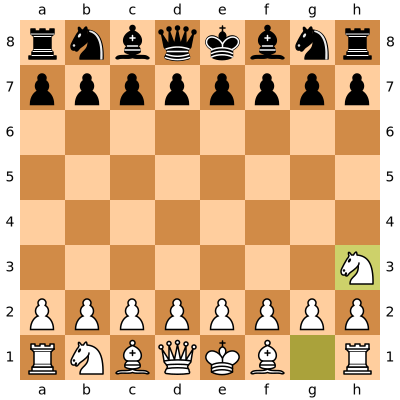

In [125]:
board #pourquoi cette position n'a pas de dernier coup?


In [0]:
import tensorflow.keras as keras

# import keras #already present in tensorflow 2.0 whitout bugs
from keras.layers import Input, Conv2D, BatchNormalization, Flatten, Dense
from keras.models import Model
def model_moves_and_score():
    NUMBER_FILTERS = 16
    shape_board = (8,8,18)
    number_moves = len(all_moves)
    #take a numpy array representing a board as input, and who plays first, and then return
    # the value of a game, number between -1 and 1
    board = Input(shape=(shape_board))
    features = Conv2D(filters=NUMBER_FILTERS,kernel_size=3,activation="relu", padding="same")(board)
    features = BatchNormalization()(features)
    features = Conv2D(filters=NUMBER_FILTERS, kernel_size=3,activation="relu", padding="same")(features)
    features = BatchNormalization()(features)
    features = Conv2D(filters=2, kernel_size=3,activation="relu", padding="same")(features)
    features = Flatten()(features)
    value_prediction = Dense(1, activation="tanh")(features) 
    policy_prediction = Dense(number_moves, activation="sigmoid")(features)
    model = Model(board, [policy_prediction, value_prediction])
    # il y a deux fonctions de pertes car 2 outputs: un vecteur de probabilites 
    #pour tout les coups possibles ainsi que le score de la position (qui definit qui a l'avantage, les blancs ou les noirs)
    model.compile(loss=["categorical_crossentropy", "mean_squared_error"], optimizer="Adam")
    # model.summary()
    return model


In [0]:
model = model_moves_and_score()


In [128]:
%%time
model = model_moves_and_score()
tree = MCTSAI(model)
number_games = 50
for i in range(number_games):
  tree.do_rollout(BoardAi())

Resultat de la partie: *
Resultat de la partie: *
Resultat de la partie: *
Resultat de la partie: 1/2-1/2
Resultat de la partie: 1/2-1/2
Resultat de la partie: *
Resultat de la partie: *
Resultat de la partie: 1/2-1/2
Resultat de la partie: *
Resultat de la partie: 1/2-1/2
Resultat de la partie: 1/2-1/2
Resultat de la partie: 1/2-1/2
Resultat de la partie: *
Resultat de la partie: 1/2-1/2
Resultat de la partie: 1/2-1/2
Resultat de la partie: 1/2-1/2
Resultat de la partie: *
Resultat de la partie: *
Resultat de la partie: 1/2-1/2
Resultat de la partie: 1/2-1/2
Resultat de la partie: 1-0
_model_select called
Here is the policy: {'g1h3': 0.0, 'g1f3': 1.0, 'b1c3': 1.0, 'b1a3': 0.0, 'h2h3': 1.0, 'g2g3': 0.0, 'f2f3': 1.0, 'e2e3': 0.0, 'd2d3': 1.0, 'c2c3': 1.0, 'b2b3': 0.0, 'a2a3': 1.0, 'h2h4': 1.0, 'g2g4': 1.0, 'f2f4': 1.0, 'e2e4': 1.0, 'd2d4': 0.0, 'c2c4': 0.0, 'b2b4': 1.0, 'a2a4': 0.0}
Here is the policy_probabilities: [0. 0. 0. ... 0. 0. 0.]


TypeError: ignored

We are simulating 10 (big) games in just 15 seconds. Let's say 1game/second

## Peut-on retourner la position du jeu d'echecs? (Ou plus precisement, peut-on changer la couleur de celui qui joue?

### Bonus: quelques ressources a regarder pour representer des parties d'echecs:
- https://en.wikipedia.org/wiki/Alpha%E2%80%93beta_pruning (a eviter de toute urgent!!)


Pris de l'article ci dessus, Ceci est la raison pour laquelle MCTS marche bien avec un reseaux de neuronne qui predit la prbailite des coups:
'''
MCTS averages over these approximation errors, which therefore tend to cancel
out when evaluating a large subtree
'''

-  The
board should be oriented to the perspective of the current player (if we want to do the same than DeepMind)

## Peut on faire comme l'algo de Google AlphagoZero, mais avec moins de (aucuns??) "Domain Knowledge"?

### Domain Knowledges from Alphago and ways around that
1. The input features describing the position, and the output features describing the move,
are structured as a set of planes; i.e. the neural network architecture is matched to the
grid-structure of the board.
- We can try to predict the "right" plane geometry of the board
- We can encode the chess position into a small vector, without any induced 2D information 

2. AlphaZero is provided with perfect knowledge of the game rules. These are used during
MCTS, to simulate the positions resulting from a sequence of moves, to determine game
termination, and to score any simulations that reach a terminal state.
- We could try to create a neural network that will never never make a mistake in the game of chess (or learn that on the fly)
3. Knowledge of the rules is also used to encode the input planes (i.e. castling, repetition,
no-progress) and output planes (how pieces move, promotions, and piece drops in shogi).
- For the input, we can learn the board representation with some freedom by embedding each case situation to a specific number instead of one one-hot encoding
4. The typical number of legal moves is used to scale the exploration noise (see below).
5. Chess and shogi games exceeding a maximum number of steps (determined by typical
game length) were terminated and assigned a drawn outcome; Go games were terminated
and scored with Tromp-Taylor rules, similarly to previous work (29).
AlphaZero did not use any form of domain knowledge beyond the points listed above.

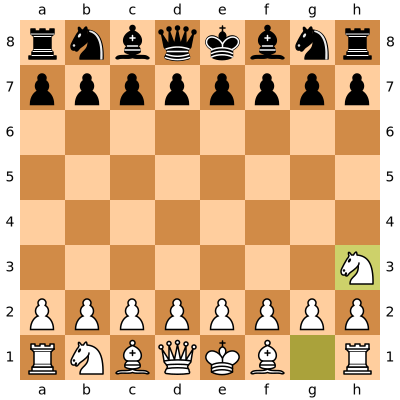

In [0]:

board = chess.Board()
board.push(list(board.legal_moves)[0])
board #eaxmple de position ou c'est au noir de jouer, et les noirs sont en haut de l'echiquier

## Renverser un jeu d'echecs

Pour renverser un jeu d'echecs, il suffit de lire chaque ligne du  fen a l'envers, par exemple:

`'rnbqkbnr/pppppppp/8/8/8/7N/PPPPPPPP/RNBQKB1R'` doit donner:
`R1BKQBNR/PPPPPPPP/....`

In [0]:
fen = board.board_fen()
def reverse_fen(fen):
  rows = [list(reversed(row)) for row in fen.split("/")]
  rows.reverse()
  fen_reversed = ""
  for row in rows:
    fen_reversed += "".join(row)  + "/"
  return fen_reversed[:-1]

R1BKQBNR/PPPPPPPP/N7/8/8/8/pppppppp/rnbkqbnr b KQkq - 2 1
[Move.from_uci('g1h3'), Move.from_uci('g1f3'), Move.from_uci('b1c3'), Move.from_uci('b1a3')]


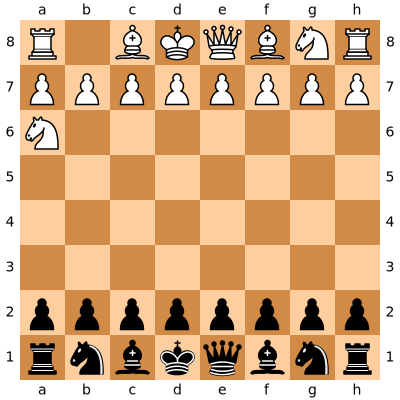

In [0]:
fen, turn, castling_part, ep_square, halfmove_clock, full_move_number = board.fen().split(" ")
fen_reversed = reverse_fen(fen)
fen_reversed = " ".join([fen_reversed, turn, castling_part, ep_square, str(int(halfmove_clock) + 1), full_move_number])
print(fen_reversed)
board_other_turn = chess.Board(fen=fen_reversed)
print(list(board_other_turn.legal_moves))
board_other_turn

In [0]:
halfmove_clock

'1'

In [0]:
board_reversed

NameError: ignored